In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

from optbinning import OptimalBinning
from sklearn.model_selection import train_test_split
import time


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train_og = train.copy()
test_og = test.copy()

In [4]:
train.shape, test.shape

((614, 13), (367, 12))

In [5]:
train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [6]:
train.columns, test.columns

(Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
        'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
        'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
       dtype='object'),
 Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
        'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
        'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
       dtype='object'))

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [8]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [9]:
train["Loan_Status"].value_counts(), train["Loan_Status"].value_counts().sum()

(Y    422
 N    192
 Name: Loan_Status, dtype: int64,
 614)

In [10]:
train["Loan_Status"].value_counts(normalize=True).round(2)

Y    0.69
N    0.31
Name: Loan_Status, dtype: float64

In [11]:
cont = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']

In [12]:
cat = ['Gender', 'Married', 'Dependents', 'Education','Self_Employed', 'Property_Area']


for col in cat:
    a = train[col].value_counts()
    b = train[col].value_counts(normalize=True)
    print(a)
    print(b)
    print("*******************************")

Male      489
Female    112
Name: Gender, dtype: int64
Male      0.813644
Female    0.186356
Name: Gender, dtype: float64
*******************************
Yes    398
No     213
Name: Married, dtype: int64
Yes    0.651391
No     0.348609
Name: Married, dtype: float64
*******************************
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64
*******************************
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
*******************************
No     500
Yes     82
Name: Self_Employed, dtype: int64
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64
*******************************
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

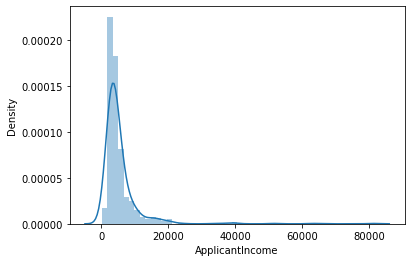

In [13]:
sns.distplot(train['ApplicantIncome'])

<AxesSubplot:title={'center':'ApplicantIncome'}, xlabel='Education'>

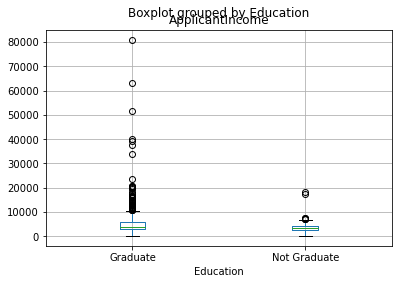

In [14]:
train.boxplot(column='ApplicantIncome', by='Education')

<AxesSubplot:xlabel='Gender'>

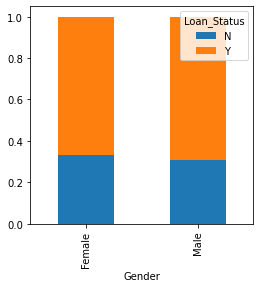

In [15]:
gg = pd.crosstab(train['Gender'],train["Loan_Status"])

gg.div(gg.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(4,4))

<AxesSubplot:xlabel='Married'>

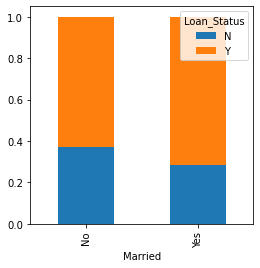

In [16]:
g2 = pd.crosstab(train['Married'],train["Loan_Status"])

g2.div(g2.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(4,4))

<AxesSubplot:xlabel='Dependents'>

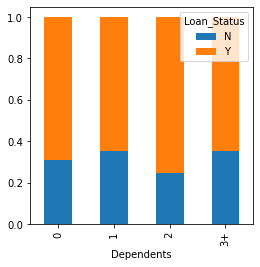

In [17]:
g3 = pd.crosstab(train['Dependents'],train["Loan_Status"])

g3.div(g3.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(4,4))

In [18]:
cat

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

<AxesSubplot:xlabel='Education'>

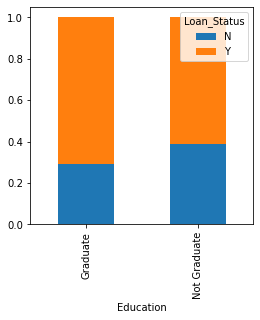

In [19]:
g4 = pd.crosstab(train['Education'],train["Loan_Status"])

g4.div(g4.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(4,4))

<AxesSubplot:xlabel='Self_Employed'>

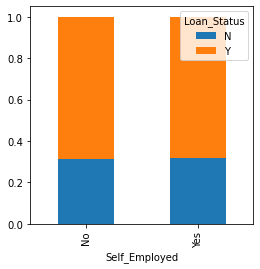

In [20]:
g5 = pd.crosstab(train['Self_Employed'],train["Loan_Status"])

g5.div(g5.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(4,4))

<AxesSubplot:xlabel='Property_Area'>

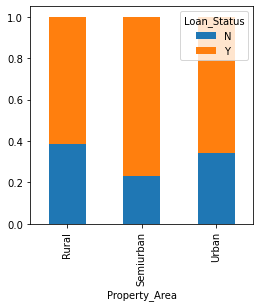

In [21]:
g6 = pd.crosstab(train['Property_Area'],train["Loan_Status"])

g6.div(g6.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(4,4))

In [22]:
train['Loan_Status'].replace('N',0, inplace=True)

train['Loan_Status'].replace('Y',1, inplace=True)

train['Dependents'].replace('3+', 3, inplace=True)
test['Dependents'].replace('3+', 3, inplace=True)

In [23]:
train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,1
610,LP002979,Male,Yes,3,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,1
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,1
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,1


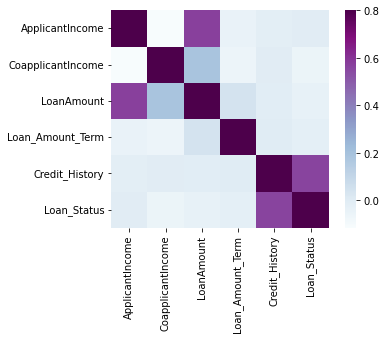

In [24]:
matrix = train.corr()
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu");

In [25]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [26]:
mode_imp = SimpleImputer(strategy="most_frequent")
med_imp = SimpleImputer(strategy="median")

In [27]:
train[cont] = med_imp.fit_transform(train[cont])

In [28]:
train[cat] = mode_imp.fit_transform(train[cat])

In [29]:
test[cont] = med_imp.fit_transform(test[cont])
test[cat] = mode_imp.fit_transform(test[cat])

In [30]:
train1 = train.copy()
test1 = test.copy()

In [31]:
train=train.drop('Loan_ID',axis=1) 
test=test.drop('Loan_ID',axis=1)

In [32]:
X = train.drop('Loan_Status',1) 
y = train.Loan_Status

In [33]:
X

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,5849.0,0.0,128.0,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900.0,0.0,71.0,360.0,1.0,Rural
610,Male,Yes,3,Graduate,No,4106.0,0.0,40.0,180.0,1.0,Rural
611,Male,Yes,1,Graduate,No,8072.0,240.0,253.0,360.0,1.0,Urban
612,Male,Yes,2,Graduate,No,7583.0,0.0,187.0,360.0,1.0,Urban


In [34]:
X=pd.get_dummies(X) 
train=pd.get_dummies(train) 
test=pd.get_dummies(test)

In [35]:
test

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_3,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5720.0,0.0,110.0,360.0,1.0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1
1,3076.0,1500.0,126.0,360.0,1.0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1
2,5000.0,1800.0,208.0,360.0,1.0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,1
3,2340.0,2546.0,100.0,360.0,1.0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,1
4,3276.0,0.0,78.0,360.0,1.0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,4009.0,1777.0,113.0,360.0,1.0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1
363,4158.0,709.0,115.0,360.0,1.0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1
364,3250.0,1993.0,126.0,360.0,1.0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0
365,5000.0,2393.0,158.0,360.0,1.0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0


In [36]:
y.head()

0    1
1    0
2    1
3    1
4    1
Name: Loan_Status, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3)

In [38]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [41]:
model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='ovr',n_jobs=1,penalty='l2',random_state=1, solver='liblinear', tol=0.0001,verbose=0, warm_start=False)
model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', n_jobs=1, random_state=1,
                   solver='liblinear')

In [42]:
pred_y = model.predict(X_val)

In [43]:
accuracy_score(y_val,pred_y)

0.8108108108108109

In [48]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.iloc[train_index],X.iloc[test_index]
    ytr,yvl = y.iloc[train_index],y.iloc[test_index]
    model = LogisticRegression(random_state=1)
    model.fit(xtr, ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print('accuracy_score',score)
    i+=1 
    pred_test = model.predict(test) 
    pred=model.predict_proba(xvl)[:,1]


1 of kfold 5
accuracy_score 0.8048780487804879

2 of kfold 5
accuracy_score 0.8373983739837398

3 of kfold 5
accuracy_score 0.7967479674796748

4 of kfold 5
accuracy_score 0.8130081300813008

5 of kfold 5
accuracy_score 0.8032786885245902


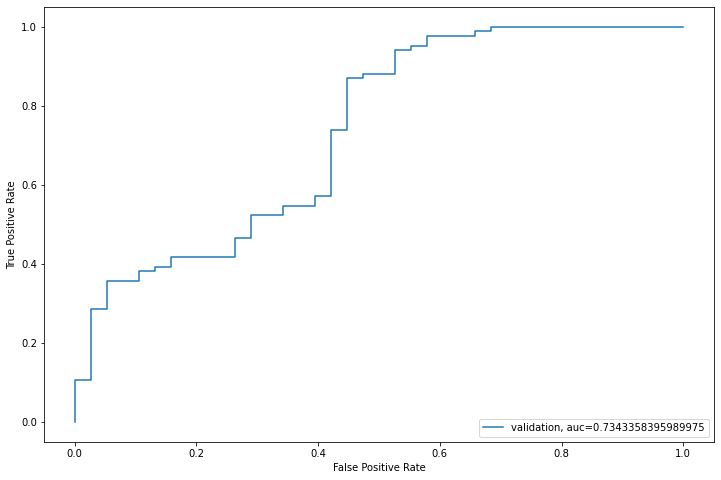

In [50]:
from sklearn import metrics 
fpr, tpr, _ = metrics.roc_curve(yvl,  pred) 
auc = metrics.roc_auc_score(yvl, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="validation, auc="+str(auc)) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [56]:
train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome'] 
test['Total_Income']=test['ApplicantIncome']+test['CoapplicantIncome']

<AxesSubplot:xlabel='Total_Income', ylabel='Density'>

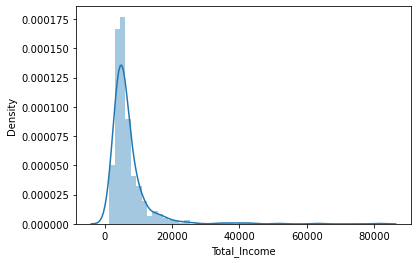

In [57]:
sns.distplot(train['Total_Income'])

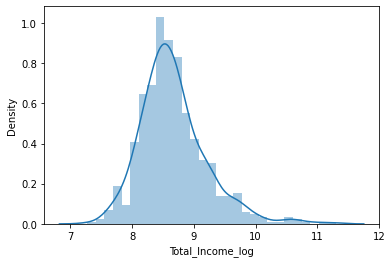

In [58]:
train['Total_Income_log'] = np.log(train['Total_Income'])
sns.distplot(train['Total_Income_log']); 
test['Total_Income_log'] = np.log(test['Total_Income'])

In [59]:
train['EMI']=train['LoanAmount']/train['Loan_Amount_Term']
test['EMI']=test['LoanAmount']/test['Loan_Amount_Term']

<AxesSubplot:xlabel='EMI', ylabel='Density'>

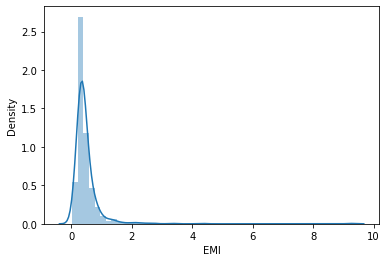

In [61]:
sns.distplot(train['EMI'])

<AxesSubplot:xlabel='Balance Income', ylabel='Density'>

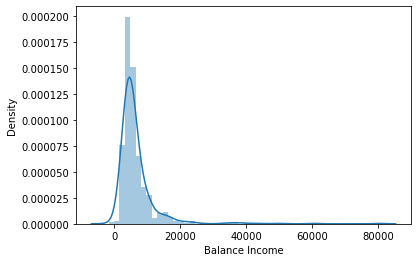

In [62]:
train['Balance Income']=train['Total_Income']-(train['EMI']*1000) # Multiply with 1000 to make the units equal 
test['Balance Income']=test['Total_Income']-(test['EMI']*1000)
sns.distplot(train['Balance Income'])

In [63]:
train=train.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1) 
test=test.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)

In [65]:
X = train.drop('Loan_Status',1) 
y = train.Loan_Status # Save target variable in separate dataset

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3)

In [88]:
def calculate_metrics(df, x):
    acc = accuracy_score(df['target'], df[x])
    prec = precision_score(df['target'], df[x])
    rec = recall_score(df['target'], df[x])
    f1 = f1_score(df['target'], df[x])
    auc = roc_auc_score(df['target'], df[x])
    
    print(f" Accuracy is {acc}")
    print(f" Precision is {prec:2f}")
    print(f" Recall is {rec:2f}")
    print(f" F1-Score is {f1:2f}")
    print(f" AUC score is {auc:2f}")

In [78]:
train = X_train.copy()
train['target'] = y_train

val = X_val.copy()
val['target'] = y_val

In [79]:
train

,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_3,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,...,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Total_Income,Total_Income_log,EMI,Balance Income,target
212,1.0,0,1,0,1,0,0,1,0,1,...,0,1,0,0,1,7787.0,8.960211,0.666667,7120.333333,1
305,1.0,0,1,1,0,0,1,0,0,0,...,1,0,0,0,1,2000.0,7.600902,0.355556,1644.444444,0
174,1.0,0,1,0,1,0,1,0,0,0,...,0,1,0,1,0,5080.0,8.533067,0.241667,4838.333333,0
504,1.0,0,1,0,1,0,1,0,0,0,...,1,0,0,1,0,5297.0,8.574896,0.413333,4883.666667,1
403,1.0,1,0,1,0,0,1,0,0,0,...,1,0,0,1,0,1963.0,7.582229,0.147222,1815.777778,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,1.0,0,1,0,1,0,0,1,0,1,...,1,0,0,1,0,4592.0,8.432071,0.319444,4272.555556,1
543,1.0,0,1,0,1,0,0,1,0,0,...,1,0,0,0,1,4763.0,8.468633,0.355556,4407.444444,1
193,1.0,0,1,1,0,0,1,0,0,1,...,1,0,0,1,0,3858.0,8.257904,0.211111,3646.888889,1
360,1.0,1,0,1,0,0,0,1,0,1,...,1,0,0,1,0,4723.0,8.460199,0.225000,4498.000000,0


In [80]:
val

,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_3,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,...,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Total_Income,Total_Income_log,EMI,Balance Income,target
264,1.0,0,1,1,0,0,1,0,0,1,...,0,1,0,1,0,5166.0,8.549854,0.355556,4810.444444,1
117,1.0,0,1,0,1,0,0,1,0,1,...,1,0,0,0,1,3612.0,8.192017,0.236111,3375.888889,1
126,1.0,0,1,0,1,1,0,0,0,1,...,1,0,1,0,0,23803.0,10.077567,1.027778,22775.222222,1
169,1.0,0,1,0,1,0,0,0,1,1,...,1,0,0,1,0,8000.0,8.987197,0.555556,7444.444444,1
412,0.0,0,1,0,1,0,1,0,0,0,...,1,0,1,0,0,6096.0,8.715388,0.605556,5490.444444,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.0,1,0,0,1,0,1,0,0,1,...,1,0,0,1,0,4786.0,8.473450,0.380556,4405.444444,1
565,1.0,0,1,0,1,0,1,0,0,0,...,1,0,1,0,0,4467.0,8.404472,0.333333,4133.666667,1
135,1.0,0,1,0,1,1,0,0,0,1,...,1,0,0,1,0,11750.0,9.371609,0.805556,10944.444444,0
222,1.0,0,1,1,0,0,1,0,0,1,...,1,0,0,1,0,5762.0,8.659040,0.400000,5362.000000,1


In [83]:
X_list = ['Credit_History', 'Gender_Female', 'Gender_Male', 'Married_No',
       'Married_Yes', 'Dependents_3', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Education_Graduate', 'Education_Not Graduate',
       'Self_Employed_No', 'Self_Employed_Yes', 'Property_Area_Rural',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Total_Income',
       'Total_Income_log', 'EMI', 'Balance Income']
y_list = ['target']

In [127]:
#Logistic
log_reg = LogisticRegression(C = 10.0, penalty ='l1', solver = 'liblinear')
log_reg.fit(train[X_list], train[y_list])

LogisticRegression(C=10.0, penalty='l1', solver='liblinear')

In [128]:
train['logistic'] = log_reg.predict(train[X_list])
calculate_metrics(train, 'logistic')

 Accuracy is 0.8181818181818182
 Precision is 0.805479
 Recall is 0.976744
 F1-Score is 0.882883
 AUC score is 0.711028


In [130]:
val['logistic'] = log_reg.predict(val[X_list])
calculate_metrics(val, 'logistic')

 Accuracy is 0.7945945945945946
 Precision is 0.761006
 Recall is 1.000000
 F1-Score is 0.864286
 AUC score is 0.703125


In [135]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score
# Define the hyperparameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0, 25,50,75,100],
    'solver': ['liblinear', 'saga']
}

# Perform grid search with cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(train[X_list], train[y_list])

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model using k-fold cross-validation
scores = cross_val_score(best_model, train[X_list], train[y_list], cv=kfold, scoring='accuracy')
average_accuracy = scores.mean()

print("Best Parameters:", best_params)
print("Average Cross-Validation Accuracy:", average_accuracy)

Best Parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Average Cross-Validation Accuracy: 0.8090013679890561


In [86]:
knn = KNeighborsClassifier(n_neighbors=15, weights = 'uniform')
# train the classifier using the training set
knn.fit(train[X_list], train[y_list])

KNeighborsClassifier(n_neighbors=15)

In [89]:
train['prediction_KNN'] = knn.predict(train[X_list])
calculate_metrics(train, 'prediction_KNN')

 Accuracy is 0.7086247086247086
 Precision is 0.712560
 Recall is 0.980066
 F1-Score is 0.825175
 AUC score is 0.525189


In [91]:
val['prediction_KNN'] = knn.predict(val[X_list])
calculate_metrics(val, 'prediction_KNN')

 Accuracy is 0.654054054054054
 Precision is 0.657459
 Recall is 0.983471
 F1-Score is 0.788079
 AUC score is 0.507361


In [92]:
#SVM
clf = svm.SVC(kernel='rbf', C=10)
# train the classifier using the training set
clf.fit(train[X_list], train[y_list])


SVC(C=10)

In [93]:
train['prediction_SVM'] = clf.predict(train[X_list])
calculate_metrics(train, 'prediction_SVM')

 Accuracy is 0.703962703962704
 Precision is 0.704225
 Recall is 0.996678
 F1-Score is 0.825309
 AUC score is 0.506151


In [94]:
val['prediction_SVM'] = clf.predict(val[X_list])
calculate_metrics(val, 'prediction_SVM')

 Accuracy is 0.6432432432432432
 Precision is 0.650273
 Recall is 0.983471
 F1-Score is 0.782895
 AUC score is 0.491736


In [95]:
#RANDOM FOREST
rfc = RandomForestClassifier(n_estimators=100)
# Train the model using the training data
rfc.fit(train[X_list], train[y_list])

RandomForestClassifier()

In [96]:
# Make predictions on the train data
train['random_forest'] = rfc.predict(train[X_list])
calculate_metrics(train, 'random_forest')

 Accuracy is 1.0
 Precision is 1.000000
 Recall is 1.000000
 F1-Score is 1.000000
 AUC score is 1.000000


In [97]:
val['random_forest'] = rfc.predict(val[X_list])
calculate_metrics(val, 'random_forest')

 Accuracy is 0.745945945945946
 Precision is 0.750000
 Recall is 0.917355
 F1-Score is 0.825279
 AUC score is 0.669615


In [98]:
#GBM
gbm = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
# Train the model using the training data

gbm.fit(train[X_list], train[y_list])

GradientBoostingClassifier(random_state=42)

In [99]:
# Make predictions on the train data
train['gbm'] = rfc.predict(train[X_list])
calculate_metrics(train, 'gbm')

 Accuracy is 1.0
 Precision is 1.000000
 Recall is 1.000000
 F1-Score is 1.000000
 AUC score is 1.000000


In [100]:
val['gbm'] = rfc.predict(val[X_list])
calculate_metrics(val, 'gbm')

 Accuracy is 0.745945945945946
 Precision is 0.750000
 Recall is 0.917355
 F1-Score is 0.825279
 AUC score is 0.669615


In [221]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(max_depth=9,min_child_weight=10,gamma=0.4,subsample=1,colsample_bytree=0.8,alpha=0.3)
#Training the model using train set
xgb_clf.fit(train[X_list], train[y_list])

XGBClassifier(alpha=0.3, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [222]:
# Make predictions on the train data
train['xgboost'] = xgb_clf.predict(train[X_list])
calculate_metrics(train, 'xgboost')

 Accuracy is 0.8414918414918415
 Precision is 0.828169
 Recall is 0.976744
 F1-Score is 0.896341
 AUC score is 0.750091


In [223]:
# Make predictions on the train data
val['xgboost'] = xgb_clf.predict(val[X_list])
calculate_metrics(val, 'xgboost')

 Accuracy is 0.8
 Precision is 0.765823
 Recall is 1.000000
 F1-Score is 0.867384
 AUC score is 0.710938


In [175]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the XGBoost classifier with initial hyperparameters
xgb = XGBClassifier()

# Define the hyperparameter grid for grid search
param_grid = {
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'alpha': [0.1, 0.2, 0.3]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(train[X_list], train[y_list])  # Replace X and y with your feature and target variables

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'alpha': 0.1, 'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 1.0}
Best Score:  0.8065663474692203


In [225]:
ss = pd.read_csv('sample_sub.csv')
ss

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N
3,LP001035,N
4,LP001051,N
...,...,...
362,LP002971,N
363,LP002975,N
364,LP002980,N
365,LP002986,N


In [227]:
test['Loan_Status'] = xgb_clf.predict(test[X_list])

In [230]:
test['Loan_ID'] = test_og['Loan_ID']

In [234]:
xg_sub = test[['Loan_ID','Loan_Status']]

xg_sub['Loan_Status'].replace(0,'N', inplace=True)
xg_sub['Loan_Status'].replace(1,'Y',inplace=True)


xg_sub

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
...,...,...
362,LP002971,Y
363,LP002975,Y
364,LP002980,Y
365,LP002986,Y


In [235]:
xg_sub = xg_sub.to_csv('xg_sub.csv')

After uploading - Your score for this submission is : 0.7777777777777778